# Notebook version of First Convolutional Neural Network

This is a step-by-step implementation of the first convolutional neural networks (CNNs) using MNIST dataset without neural network framework. 

input [1x28x28]- conv (5x5, stride=1, pad=0: 30x1x5x5) [30x24x24] -maxpool-linear(FC)-linear(FC) - output [10]  




In this example, only 1000 training images are used to save training time.

In [1]:
import sys, os
import os.path
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

### Download source codes from my github repository

In [2]:
%%shell
git clone https://github.com/HitoshiIyatomi/IIP1

Cloning into 'IIP1'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 167 (delta 50), reused 148 (delta 31), pack-reused 0
Receiving objects: 100% (167/167), 2.38 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (50/50), done.


### download MNIST dataset

If "load_mnist" below does not work (sometimes it does not work due to server side error), use different loader in the lower block.



In [ ]:
# if it does not work, use different code in lower block
from IIP1.dataset.mnist import load_mnist
# load MNIST data
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

print(x_train.shape)
print(x_test.shape)
print(t_train.shape)
print(t_test.shape)

This is alternative MNIST data source.  
This dataset contain 50000 training and 10000 test dataset.  

For reducing training time, this example reduces the training images.
(see below)


<class 'gzip.GzipFile'>
<class 'numpy.ndarray'>
(50000, 784)
(10000, 784)
(50000,)
(10000,)
To reduce the training time, we use only 1000 training and 1000 test images
(1000, 784)
(1000, 784)


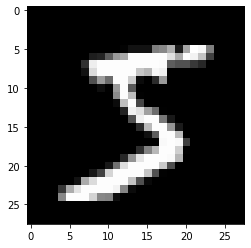

In [14]:
# if above does not work, use different implementation 
# 
from pathlib import Path
import requests
import gzip
import pickle

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        print(type(f))
        ((x_train, t_train), (x_test, t_test), _) = pickle.load(f, encoding="latin-1")

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(type(x_train))
print(x_train.shape)
print(x_test.shape)
print(t_train.shape)
print(t_test.shape)

# if we reduce the number of training data
# in this example,  we use 1000 data for train, other 1000 data for test
print("To reduce the training time, we use only 1000 training and 1000 test images")
# of course, you can chance the number
x_train = x_train[:1000]
x_test = x_test[:1000]
print(x_train.shape)
print(x_test.shape)

In [15]:
# reshape dataset
# (N, 784) -> (N, 1, 28, 28)
num_train_data = x_train.shape[0]
num_test_data  = x_test.shape[0]

x_train = x_train.reshape(num_train_data, 28, -1)
x_train = np.expand_dims(x_train, -1)

print(x_train.shape)
x_test = x_test.reshape(num_test_data, 28, -1)
x_test = np.expand_dims(x_test, -1)
print(x_test.shape)

x_train=np.transpose(x_train,(0,3,1,2))
print(f'x_train.shape = {x_train.shape}')

x_test=np.transpose(x_test,(0,3,1,2))
print(f'x_test.shape = {x_test.shape}')

(1000, 28, 28, 1)
(1000, 28, 28, 1)
x_train.shape = (1000, 1, 28, 28)
x_test.shape = (1000, 1, 28, 28)


### Definition of CNN model

input [1x28x28]- conv (5x5, stride=1, pad=0: 30x1x5x5) [30x24x24] -maxpool-linear(FC)-linear(FC) - output [10]   

(simple_convnet.py)

In [16]:
import sys, os
import pickle
import numpy as np
from collections import OrderedDict
from IIP1.common.gradient import numerical_gradient
from IIP1.common.layers import *

class SimpleConvNet:
    """simple ConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : input size（784 if MNIST）
    hidden_size_list : # neurons in hidden layers（e.g. [100, 100, 100]）
    output_size : output size（10 if MNIST）
    activation : 'relu' or 'sigmoid'
     weight_init_std : SD of initial weight（e.g. 0.01）
        'relu' or 'he': using the He's method for network initialization
        'sigmoid' or 'xavier': useint the Xavier's method for network initialization 
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # initialization of weights
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # definition of layers in the network
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """calculation of loss
        x: input data t: training label
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """calculation of numerical gradient
        Parameters
        ----------
        x : input data
        t : training label
        Returns
        -------
        A dictionary variable with a gradient for each layer
            grads['W1'], grads['W2'],...gradients for weights 
            grads['b1'], grads['b2'],...gradients for biases
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """calculation of gradient (back-prop)
        Parameters
        ----------
        x : input data
        t : training label
        Returns
        -------
        A dictionary variable with a gradient for each layer
            grads['W1'], grads['W2'],...gradients for weights 
            grads['b1'], grads['b2'],...gradients for biases
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # setting
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

### Training the CNN model



Trainer class: 
Training of neural networks with minibatch
you can set general training properties such as
              training epochs, mini-batch size, optimizer, learning rate etc.
  

In [17]:
from IIP1.common.optimizer import *

class Trainer:
    """class to train neural networks
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimizer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprop':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        #if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: \
                print("=== epoch:" + str(self.current_epoch) + \
                    ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [9]:
max_epochs = 30

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# save network parameters
network.save_params("params.pkl")
print("Saved Network Parameters!")

=== epoch:1, train acc:0.248, test acc:0.246 ===
=== epoch:2, train acc:0.503, test acc:0.446 ===
=== epoch:3, train acc:0.72, test acc:0.658 ===
=== epoch:4, train acc:0.762, test acc:0.71 ===
=== epoch:5, train acc:0.805, test acc:0.745 ===
=== epoch:6, train acc:0.838, test acc:0.819 ===
=== epoch:7, train acc:0.879, test acc:0.823 ===
=== epoch:8, train acc:0.864, test acc:0.783 ===
=== epoch:9, train acc:0.892, test acc:0.837 ===
=== epoch:10, train acc:0.881, test acc:0.829 ===
=== epoch:11, train acc:0.915, test acc:0.835 ===
=== epoch:12, train acc:0.915, test acc:0.836 ===
=== epoch:13, train acc:0.923, test acc:0.858 ===
=== epoch:14, train acc:0.937, test acc:0.856 ===
=== epoch:15, train acc:0.938, test acc:0.875 ===
=== epoch:16, train acc:0.942, test acc:0.87 ===
=== epoch:17, train acc:0.939, test acc:0.869 ===
=== epoch:18, train acc:0.953, test acc:0.874 ===
=== epoch:19, train acc:0.956, test acc:0.886 ===
=== epoch:20, train acc:0.963, test acc:0.876 ===
=== epoch:21

### Draw a training curve

If we use larger data (or more training epoch), the performance becomes better. 

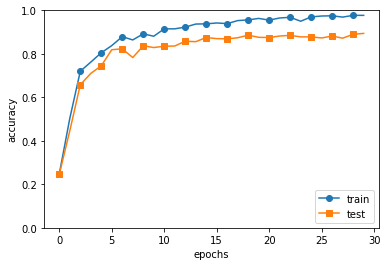

In [11]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## Visualize the obtained convolution filters



In [18]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

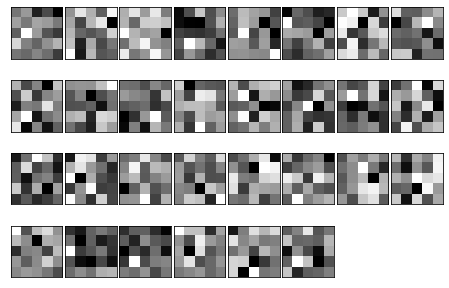

In [21]:
# weights just after the initialization
network = SimpleConvNet()
filter_show(network.params['W1'])

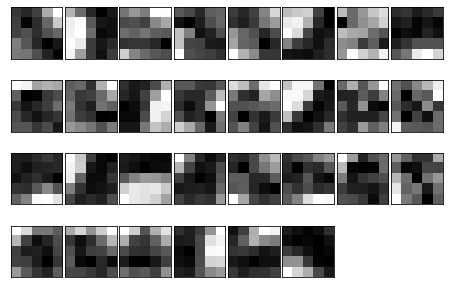

In [22]:
# weights after the training
network.load_params("params.pkl")
filter_show(network.params['W1'])